# Research Skills: Spatiotemporal Data Analysis
# Worksheet 4 - Fundamentals for Spatial Data Analysis

Sharon Ong, Department of Cognitive Science and Artificial Intelligence – Tilburg University

You will be introduced to the concepts of (geo)spatial data, and more specifically to vector data.


You will then learn how to represent such data in a GeoDataFrame using the GeoPandas library, and the basics to read, explore and visualize such data. And you will exercise all this with some datasets about the Netherlands.

One of the key aspects of geospatial data is how they relate to each other in space. In this worksheet, you will learn the spatial relationships such as spatial weights, spatial lag.   

Spatial Point Process Analysis
1. Visualization of Spatial Point Processes
2. Centrography
3. Density functions: Kernel Density Functions, Quadrant Density Functions
4. Average Nearest Neighbour Distance
5. Ripley's K Functions

Spatial Lattice Data Analysis

6. Creating a GeoDataFrame
7. Handling maps (lattice data) with Python
8. Displaying vector data


### 0. Setup
Please specify in the next cell if you are working from Google Colab or from your own computer. Also indicate if you already have the necessary libraries installed.

In [1]:
COLAB = False
LIBRARIES_INSTALLED = False

In [2]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    # Load the contents of the directory
    !ls
    # Change your working directory to the folder where you stored your files, e.g.
    %cd /content/drive/My Drive/Colab Notebooks/STDA

if not LIBRARIES_INSTALLED:
    !pip install seaborn
    !pip install contextily
    !pip install pointpats
    !pip install mapclassify

from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import contextily as ctx
import pointpats

# 1. Visualization of Spatial Point Processes

An example of spatial point process are geo-tagged photos. Geo-tagged photos uploaded to online services is creating new ways for researchers to study and understand cities. Where do people take pictures? When are those pictures taken? Why do certain places attract many more photographers than others? We will use the Tokyo Photographs Dataset for this exercise. This dataset contains geo-tagged Flickr photos from Tokyo. We will treat the phenomena represented in the data as events: photos could be taken of any place in Tokyo, but only certain locations are captured.

The following code loads the dataset. The dataset contains the following information about the sample of 10,000 photographs: the ID of the user who took the photo; the location expressed as latitude and longitude columns; a transformed version of those coordinates expressed in Pseudo Mercator; the timestamp when the photo was taken; and the URL where the picture they refer to is stored online.

In [3]:
db = pd.read_csv(join('data4', 'tokyo_clean.csv'))

# To find out more information about the dataset.
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               10000 non-null  object 
 1   longitude             10000 non-null  float64
 2   latitude              10000 non-null  float64
 3   date_taken            10000 non-null  object 
 4   photo/video_page_url  10000 non-null  object 
 5   x                     10000 non-null  float64
 6   y                     10000 non-null  float64
dtypes: float64(4), object(3)
memory usage: 547.0+ KB


Plot the longitude and latitude on a scatter plot with a dot size (`s`) of 0.5.

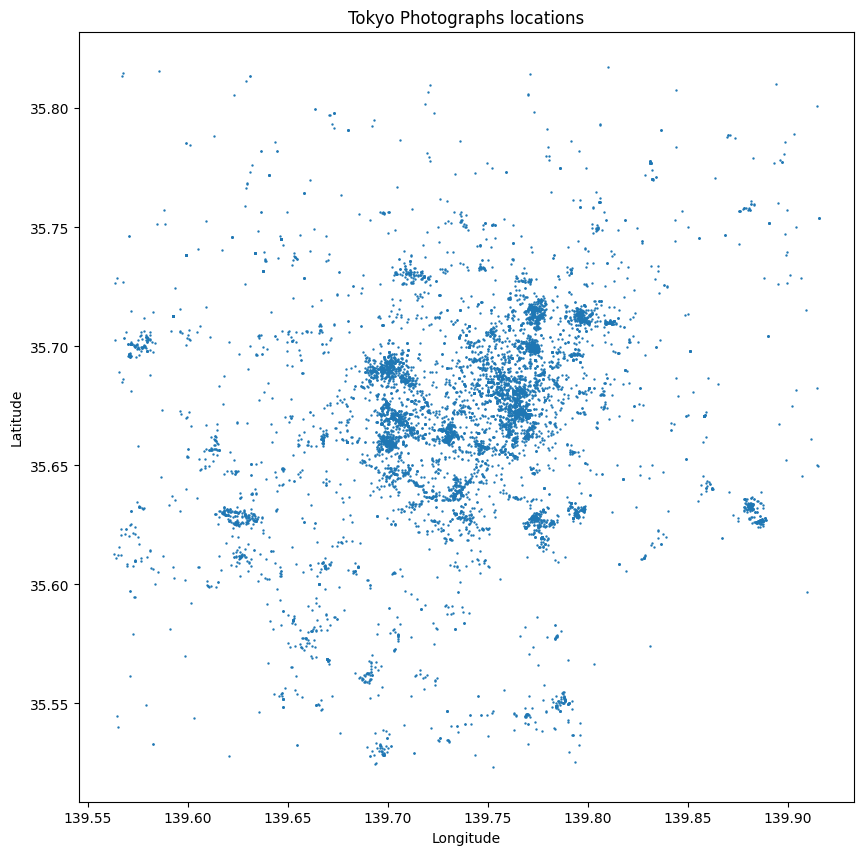

In [4]:
#
# Your code goes here
#

plt.figure(figsize=(10, 10))

plt.scatter(db['longitude'], db['latitude'], s=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Tokyo Photographs locations')
plt.show()

The code below creates a scatter plot the seaborn package and displays the map in the background.

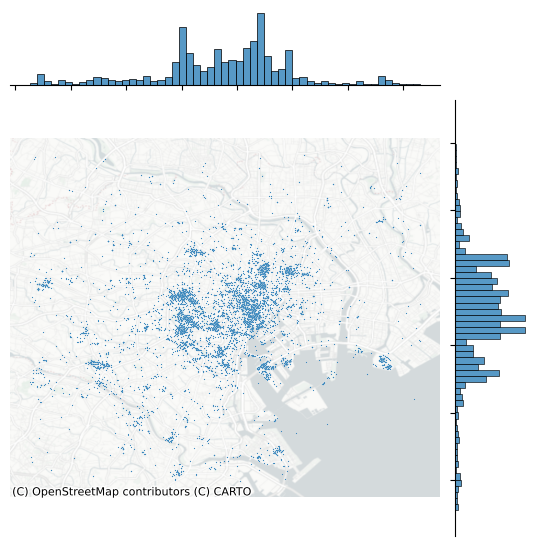

In [5]:
# Create scatter plot with histograms on axes
joint_axes = sns.jointplot(x='longitude', y='latitude', data=db, s=0.75)

# Add basemap
ctx.add_basemap(joint_axes.ax_joint, crs="EPSG:4326", source=ctx.providers.CartoDB.PositronNoLabels)

# Remove axes
joint_axes.ax_joint.set_axis_off()

# 2. Centrography
Centrography is the analysis of centrality (general location and dispersion) in a point pattern. These measures are useful because they allow us to summarize spatial distributions in smaller sets of information (e.g. a single point). The following code computes the mean and median center of the dataset.

In [6]:
mean_center = pointpats.centrography.mean_center(db[['x', 'y']])
med_center = pointpats.centrography.euclidean_median(db[['x', 'y']])

The following code plots the mean and median points and marginal lines.  

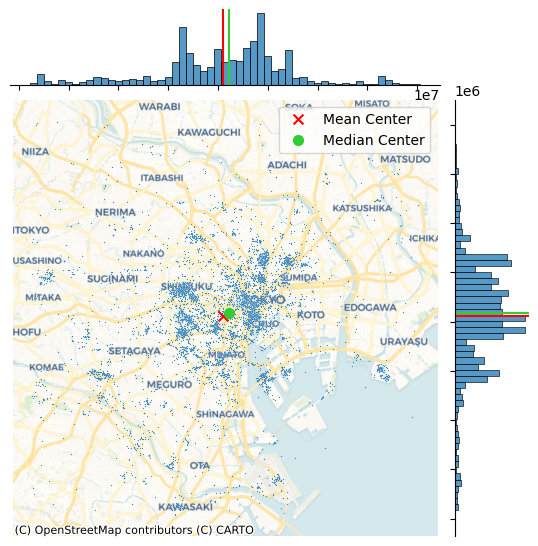

In [7]:
# Generate scatter plot
joint_axes = sns.jointplot(x='x', y='y', data=db, s=0.75)

# Add mean point and marginal lines
joint_axes.ax_joint.scatter(*mean_center, color='red', marker='x', s=50, label='Mean Center')
joint_axes.ax_marg_x.axvline(mean_center[0], color='red')
joint_axes.ax_marg_y.axhline(mean_center[1], color='red')

# Add median point and marginal lines
joint_axes.ax_joint.scatter(*med_center, color='limegreen', marker='o', s=50, label='Median Center')
joint_axes.ax_marg_x.axvline(med_center[0], color='limegreen')
joint_axes.ax_marg_y.axhline(med_center[1], color='limegreen')

# Legend
joint_axes.ax_joint.legend()

# Add basemap
ctx.add_basemap(joint_axes.ax_joint, source=ctx.providers.CartoDB.Voyager)

# Remove axes
joint_axes.ax_joint.set_axis_off()

A measure of dispersion that is common in centrography is the *standard distance*. This measure provides the average distance away from the center of the point cloud (such as measured by the center of mass). To compute the standard distance, you can use the `std_distance` function in `pointpats.centrography`. Compute the *standard distance* of the dataset.


In [8]:
#
# Your code goes here
#

std_dist = pointpats.centrography.std_distance(db[['x', 'y']])
std_dist

8778.218564382098

Another helpful visualization is the *standard deviational ellipse*, or *standard ellipse* which shows the dispersion and orientation of the dataset. The following code first computes the axes, and rotation of the ellipse. Next, the code shows you how to display the ellipse on the map.



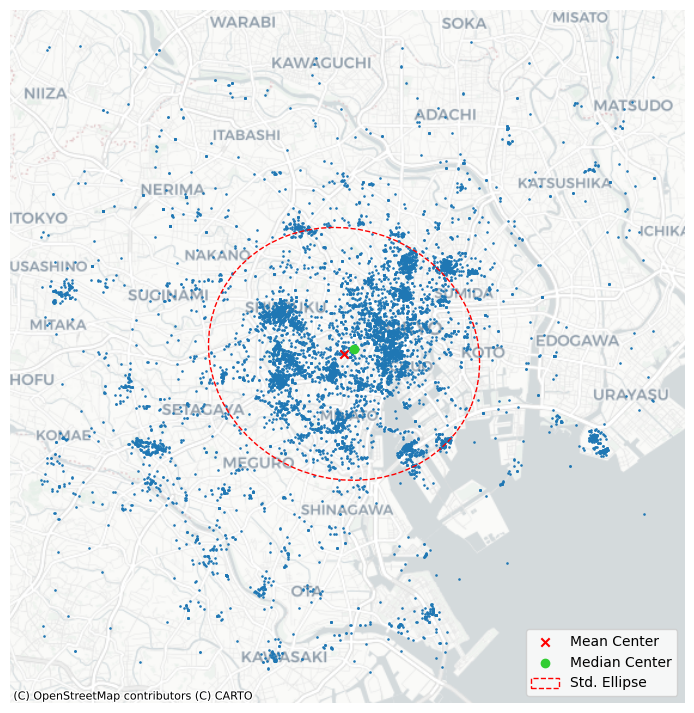

In [9]:
from matplotlib.patches import Ellipse

major, minor, rotation = pointpats.centrography.ellipse(db[['x','y']])

# Set up figure and axis
fig, ax = plt.subplots(figsize=(9, 9))

# Plot photograph points
ax.scatter(db['x'], db['y'], s=0.75)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                  width=major*2, # centrography.ellipse only gives half the axis
                  height=minor*2,
                  angle=np.rad2deg(rotation), # Angles for this are in degrees, not radians
                  facecolor='none', # Aesthetics
                  edgecolor='red',
                  linestyle='--',
                  label='Std. Ellipse')
ax.add_patch(ellipse)
ax.legend()

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Remove axes
ax.set_axis_off()

In the code block below:

1. Find the users that have posted the most pictures in Tokyo using pandas' `.mode()` method
2. Create a dataframe that only contains the rows from one of these users
3. Find the mean center and euclidean mean of this user
4. Plot the user's photo locations as a scatter plot, the centroids, and the std. ellipse

top user mean center: [15547780.63628639  4251507.66060941]
top user median center: [15543726.82283655  4249927.06513279]


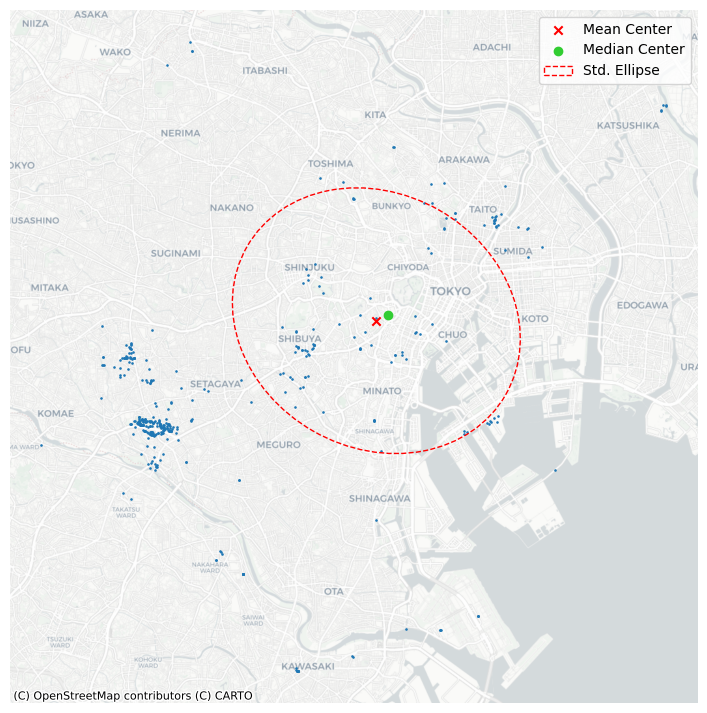

In [10]:
#
# Your code goes here
#

# 1
top_users = db['user_id'].mode()

# 2
top_user_photos = db[db['user_id'] == top_users[0]]

# 3
top_user_mean_center = pointpats.centrography.mean_center(top_user_photos[['x', 'y']])
top_user_med_center = pointpats.centrography.euclidean_median(top_user_photos[['x', 'y']])
print(f'top user mean center: {top_user_mean_center}')
print(f'top user median center: {top_user_med_center}')

# 4
major, minor, rotation = pointpats.centrography.ellipse(top_user_photos[['x','y']])

# Set up figure and axis
fig, ax = plt.subplots(figsize=(9, 9))

# Plot photograph points
ax.scatter(top_user_photos['x'], top_user_photos['y'], s=0.75)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                  width=major*2, # centrography.ellipse only gives half the axis
                  height=minor*2,
                  angle=np.rad2deg(rotation), # Angles for this are in degrees, not radians
                  facecolor='none', # Aesthetics
                  edgecolor='red',
                  linestyle='--',
                  label='Std. Ellipse')
ax.add_patch(ellipse)
ax.legend()

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Remove axes
ax.set_axis_off()


# 3 Density Plots
When too many photos are concentrated in some areas of, plotting opaque dots on top of one another can make it hard to discern any pattern and explore its nature.

## 3.1 Kernel Density Plots
Kernel density estimation (KDE): an empirical approximation of the probability density function. Instead of overlaying a grid of squares and count how many points fall within each, we can use a Kernel density estimation (KDE) to lay kernel functions over a grid of points with different weight based on the distance. These counts are then aggregated to generate a global surface with probability. The most common kernel function is the Gaussian one, which applies a normal distribution to weight points.

The code belows generates a number of random points; where there is no clusteirng or dispersion effect. In point pattern analysis, this is known as a *Poisson point process*.

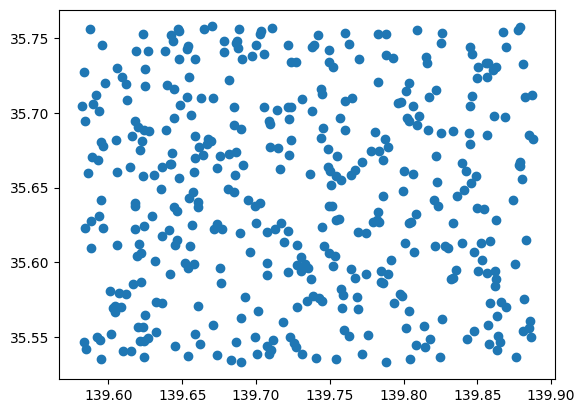

In [11]:
user = db.loc[db.user_id == '95795770@N00']
coordinates = user[['longitude','latitude']].values
points = pointpats.random.poisson(coordinates, size=len(coordinates))

plt.scatter(points[:, 0], points[:, 1])

The code below creates a kernel density plot with a shading of 50 gradients and a transpancy of 55%


<Axes: >

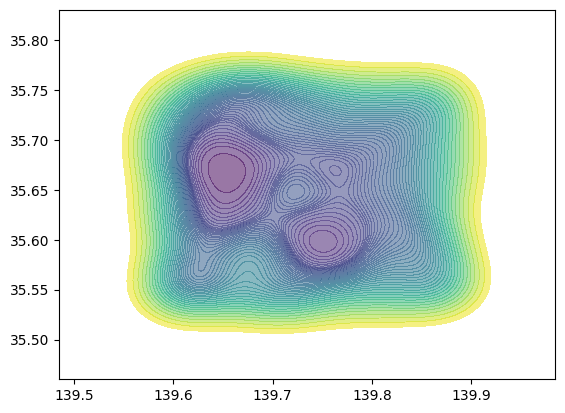

In [12]:
sns.kdeplot(x=points[:, 0], y=points[:, 1], n_levels=50, fill=True, alpha=0.55, cmap='viridis_r')

Display the Kernel Density Plot for the Tokyo Dataset with the map in the background. Set `n_levels` to 50 and `cmap` to 'viridis_r'.

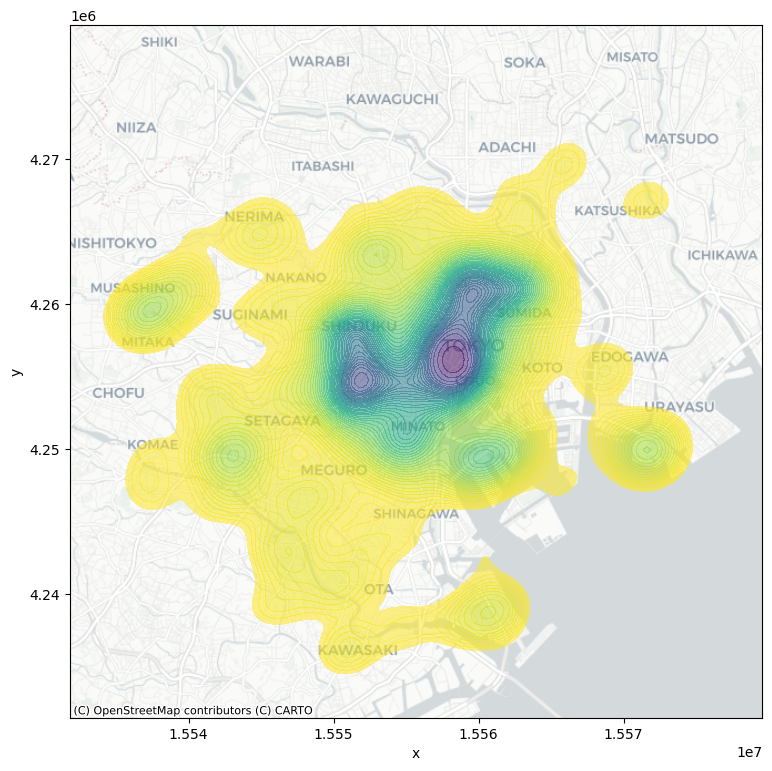

In [13]:
#
# Your code goes here
#

fig, ax = plt.subplots(figsize=(9, 9))
sns.kdeplot(x=db['x'], y=db['y'], n_levels=50, fill=True, alpha=0.55, cmap='viridis_r')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

Display the Kernel Density Plot for the user with the most uploaded photos, use the same settings as the previous plot, but set `cmap` to 'jet_r'.

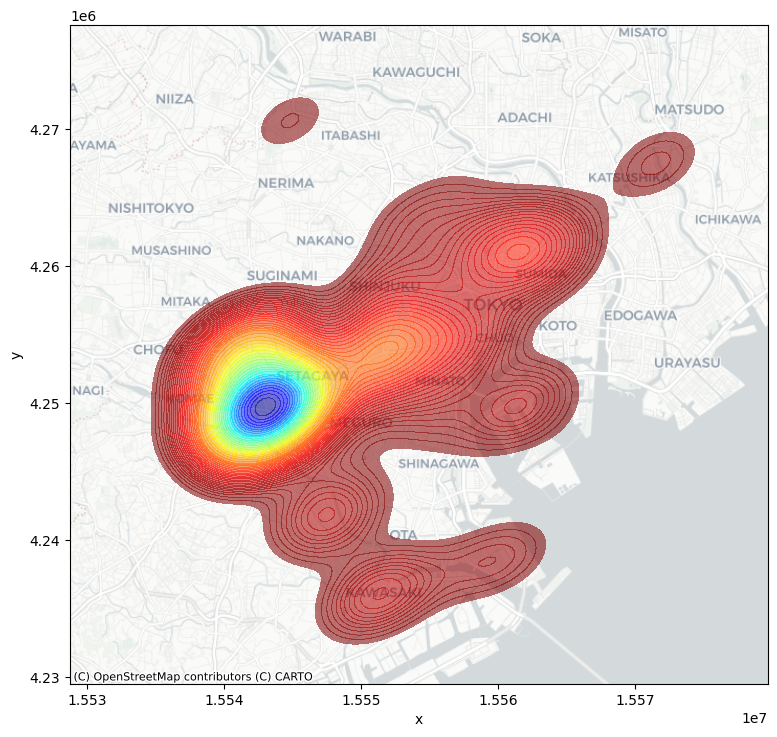

In [14]:
#
# Your code goes here
#

fig, ax = plt.subplots(figsize=(9, 9))
sns.kdeplot(x=top_user_photos['x'], y=top_user_photos['y'], n_levels=50, fill=True, alpha=0.55, cmap='jet_r')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

## 3.2 Quadrant Density Plot

Quadrant statistics examines the spatial distribution of points in an area by counting the observations that fall within a given cell. A quadrant statistics examines the *evenness* of the distribution over cells using a $\chi^2$ statistical test common in the analysis of contingency tables.

The code below plots applies quadrant statistics on the previously generated random spatial process and plots the result.


<Axes: title={'center': 'Quadrat Count'}>

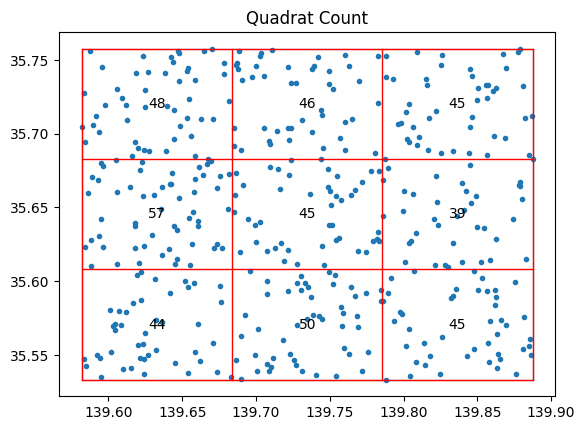

In [15]:
qstat = pointpats.QStatistic(points)
qstat.plot()

The code belows displays the p value of the $\chi^2$, which shows that p value is large and not significant.  

In [16]:
qstat.chi2_pvalue

0.8412962728920697

Compute the quadrant statistics on the data from the `coordinates` variable. Display the Quadrant plot and compute the p value of the $\chi^2$.
Is the p value significant?


p: 0.0
The p value 0.0 is significant.


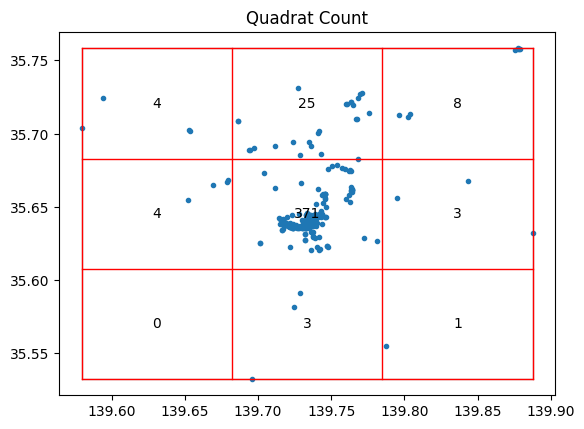

In [17]:
#
# Your code goes here
#

qstat = pointpats.QStatistic(coordinates)
qstat.plot()
p = qstat.chi2_pvalue

print(f'p: {p}')
if qstat.chi2_pvalue < 0.05:
    print(f'The p value {p} is significant.')

# 4. Average Nearest Neighbour
The following code compute the nearest neighbour for the random point process and draws an arrow from each point to its nearest neighbour.


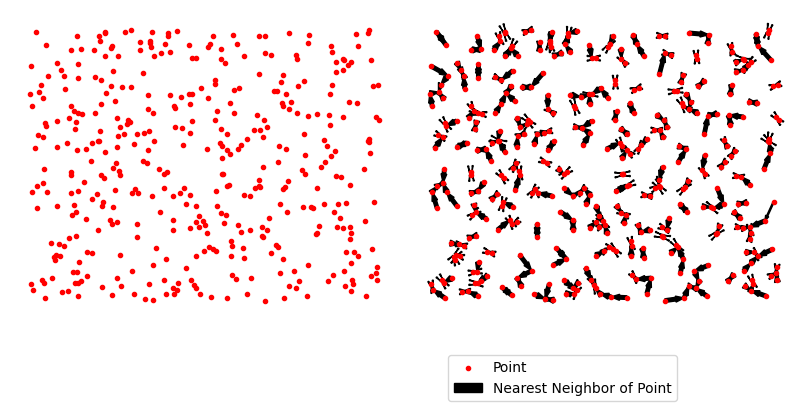

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True, layout='constrained')

axs[0].scatter(*points.T, color='red', marker='.')
axs[1].scatter(*points.T, color='red', zorder=100, marker='.', label='Point')

pp = pointpats.PointPattern(points)
nn_ixs, nn_ds = pp.knn(1)

first = True
for coord, nn_ix, nn_d in zip(points, nn_ixs, nn_ds):
    dx, dy = points[nn_ix].squeeze() - coord
    if first:
        first = False
        arrow = axs[1].arrow(*coord, dx, dy, length_includes_head=True, facecolor='k', width=0.001, label='Nearest Neighbor of Point')
    else:
        arrow = axs[1].arrow(*coord, dx, dy, length_includes_head=True, facecolor='k', width=0.003, head_width=0.005)

axs[0].set_axis_off()
axs[1].set_axis_off()
axs[1].legend(bbox_to_anchor=(0.7, -0.1))
plt.show()

# 5. K(d) functions

K(d) fucntions summarizes the density between points for all distances. It consists of dividing the mean of  sum of the number of points at different distance lags for each point by the entire area. The following code applies a K function on the random point process and plots it.

Text(0, 0.5, 'K')

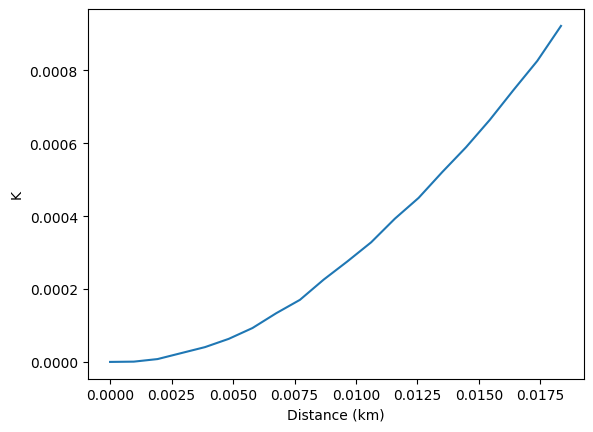

In [19]:
dist, k = pointpats.k(points)

plt.plot(dist, k)
plt.xlabel('Distance (km)')
plt.ylabel('K')

Compute the K function for the single user coordinates from the Tokyo dataset   



Text(0, 0.5, 'K')

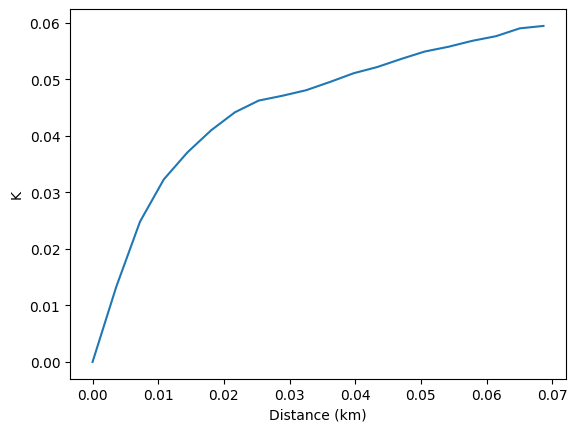

In [20]:
#
# Your code goes here
#

dist, k = pointpats.k(coordinates)

plt.plot(dist, k)
plt.xlabel('Distance (km)')
plt.ylabel('K')

# 6. Creating a GeoDataFrame
The following loads a csv file of some major cities in North Brabant and converts the dataset to a GeoDataFrame.  
1. Inspect the first 5 rows of the cities dataframe and the  with the head() method. Do you see the columns with coordinates?
2. Visualize the locations of the cities (you may use the `gdf.plot()` or matplotlib)

              city        lat       lng      country iso2          admin  \
0        Eindhoven  51.450000  5.466667  Netherlands   NL  Noord-Brabant   
1          Tilburg  51.576922  5.106331  Netherlands   NL  Noord-Brabant   
2            Breda  51.566667  4.800000  Netherlands   NL  Noord-Brabant   
3  s-Hertogenbosch  51.700196  5.306806  Netherlands   NL  Noord-Brabant   
4   Bergen op Zoom  51.494492  4.283509  Netherlands   NL  Noord-Brabant   

  capital  population  population_proper  
0   minor    398053.0           231642.0  
1   minor    217259.0           217259.0  
2   minor    183873.0           183873.0  
3   admin    154205.0           154205.0  
4   minor         NaN                NaN  


Text(0.5, 1.0, 'Cities in Noord-Brabant')

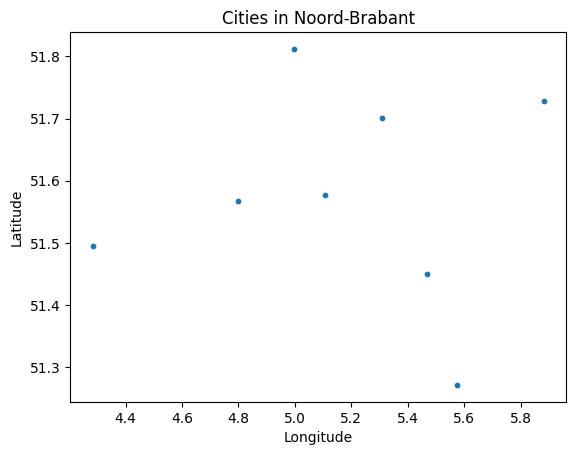

In [21]:
cities = pd.read_csv(join('data4', 'nl_noord-brabant_main.csv'))
print(cities.head())
gdf = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities.lng, cities.lat))

#
# Your code goes here
#

# 1
cities.head()

# 2 
plt.scatter(cities['lng'], cities['lat'], s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Cities in Noord-Brabant')


# 7. Handling Choropleth maps with Python
GeoDataFrames can be used to store simple geographical features, along with their non-spatial attribute. The GeoPandas library has functions to read, explore and visualize such data.  These geographical features include points (therefore addresses and locations), line strings (therefore streets, highways and boundaries), polygons (countries, provinces, tracts of land), and multi-part collections of these type. The following code loads a shapefile of all the municipalities in the Netherlands.

GM_CODE          GM_NAAM H2O         OAD        STED  BEV_DICHTH  \
0  GM0034           Almere  JA -99999999.0 -99999999.0 -99999999.0   
1  GM0050         Zeewolde  JA -99999999.0 -99999999.0 -99999999.0   
2  GM0060          Ameland  JA -99999999.0 -99999999.0 -99999999.0   
3  GM0072        Harlingen  JA -99999999.0 -99999999.0 -99999999.0   
4  GM0088  Schiermonnikoog  JA -99999999.0 -99999999.0 -99999999.0   

     AANT_INW    AANT_MAN  AANT_VROUW  P_00_14_JR  ...  P_GEBBL_EU  \
0 -99999999.0 -99999999.0 -99999999.0 -99999999.0  ... -99999999.0   
1 -99999999.0 -99999999.0 -99999999.0 -99999999.0  ... -99999999.0   
2 -99999999.0 -99999999.0 -99999999.0 -99999999.0  ... -99999999.0   
3 -99999999.0 -99999999.0 -99999999.0 -99999999.0  ... -99999999.0   
4 -99999999.0 -99999999.0 -99999999.0 -99999999.0  ... -99999999.0   

   P_GEBBL_NE     OPP_TOT    OPP_LAND   OPP_WATER  JRSTATCODE  JAAR  \
0 -99999999.0 -99999999.0 -99999999.0 -99999999.0  2023GM0034  2023   
1 -99999999.0 -99999999.0 -99999999.0 -99999999.0  2023GM0050  2023   
2 -99999999.0 -99999999.0 -99999999.0 -99999999.0  2023GM0060  2023   
3 -99999999.0 -99999999.0 -99999999.0 -99999999.0  2023GM0072  2023   
4 -99999999.0 -99999999.0 -99999999.0 -99999999.0  2023GM0088  2023   

                          layer  \
0  2023 — gemeente_2023_v1water   
1  2023 — gemeente_2023_v1water   
2  2023 — gemeente_2023_v1water   
3  2023 — gemeente_2023_v1water   
4  2023 — gemeente_2023_v1water   

                                                path  \
0  \\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...   
1  \\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...   
2  \\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...   
3  \\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...   
4  \\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...   

                                            geometry  
0  MULTIPOLYGON (((150087.299 479382.379, 150000....  
1  MULTIPOLYGON (((155047.320 474836.246, 155049....  
2  POLYGON ((196000.000 608000.000, 195250.000 60...  
3  MULTIPOLYGON (((158000.000 581000.000, 158331....  
4  POLYGON ((219000.000 616201.447, 219000.000 61...  

[5 rows x 39 columns]

GM_CODE          GM_NAAM H2O         OAD        STED  BEV_DICHTH  \
0  GM0034           Almere  JA -99999999.0 -99999999.0 -99999999.0   
1  GM0050         Zeewolde  JA -99999999.0 -99999999.0 -99999999.0   
2  GM0060          Ameland  JA -99999999.0 -99999999.0 -99999999.0   
3  GM0072        Harlingen  JA -99999999.0 -99999999.0 -99999999.0   
4  GM0088  Schiermonnikoog  JA -99999999.0 -99999999.0 -99999999.0   

     AANT_INW    AANT_MAN  AANT_VROUW  P_00_14_JR  ...  P_GEBBL_NE  \
0 -99999999.0 -99999999.0 -99999999.0 -99999999.0  ... -99999999.0   
1 -99999999.0 -99999999.0 -99999999.0 -99999999.0  ... -99999999.0   
2 -99999999.0 -99999999.0 -99999999.0 -99999999.0  ... -99999999.0   
3 -99999999.0 -99999999.0 -99999999.0 -99999999.0  ... -99999999.0   
4 -99999999.0 -99999999.0 -99999999.0 -99999999.0  ... -99999999.0   

      OPP_TOT    OPP_LAND   OPP_WATER  JRSTATCODE  JAAR  \
0 -99999999.0 -99999999.0 -99999999.0  2023GM0034  2023   
1 -99999999.0 -99999999.0 -99999999.0  2023GM0050  2023   
2 -99999999.0 -99999999.0 -99999999.0  2023GM0060  2023   
3 -99999999.0 -99999999.0 -99999999.0  2023GM0072  2023   
4 -99999999.0 -99999999.0 -99999999.0  2023GM0088  2023   

                          layer  \
0  2023 — gemeente_2023_v1water   
1  2023 — gemeente_2023_v1water   
2  2023 — gemeente_2023_v1water   
3  2023 — gemeente_2023_v1water   
4  2023 — gemeente_2023_v1water   

                                                path  \
0  \\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...   
1  \\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...   
2  \\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...   
3  \\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...   
4  \\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...   

                                            geometry  \
0  MULTIPOLYGON (((150087.299 479382.379, 150000....   
1  MULTIPOLYGON (((155047.320 474836.246, 155049....   
2  POLYGON ((196000.000 608000.000, 195250.000 60...   
3  MULTIPOLYGON (((158000.000 581000.000, 158331....   
4  POLYGON ((219000.000 616201.447, 219000.000 61...   

                                       coords  
0  [(142126.64086094766, 496236.14450001717)]  
1   [(166284.93327499047, 480787.9726500511)]  
2             [(179375.0, 602583.3329999447)]  
3    [(147757.0088231566, 571859.8220000267)]  
4    [(215349.3268323614, 610399.8863501549)]  

[5 rows x 40 columns]

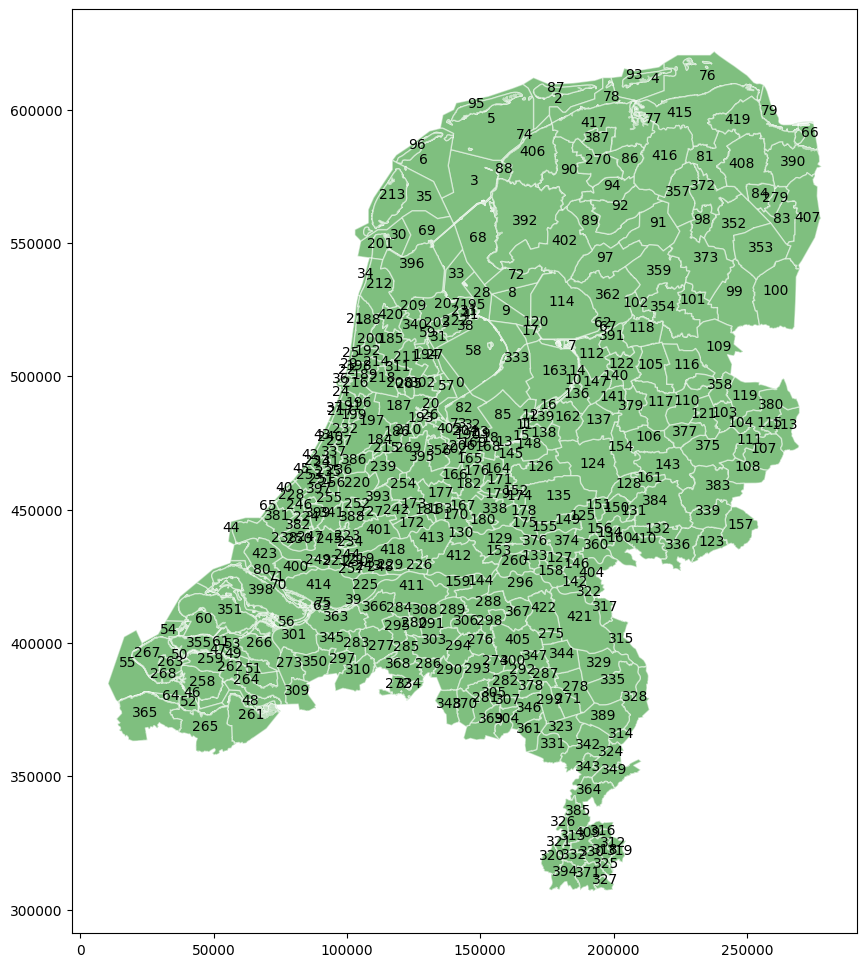

In [22]:
gemeenten = gpd.read_file(join('data4', 'wijkbuurtkaart_2023_v1', 'gemeenten_2023_v1.shp'))

# Display the shapes (e.g. polygons and multi-polygons) with a transparency of 0.5,
# green face color and black edges
ax = gemeenten.plot(figsize=(12, 12), alpha=0.5, facecolor='g', edgecolor='w')

display(gemeenten.head())

# Annotate the polygon with its index
gemeenten['coords'] = gemeenten['geometry'].apply(lambda x: x.representative_point().coords[:])

display(gemeenten.head())

gemeenten['coords'] = [coords[0] for coords in gemeenten['coords']]
for idx, row in gemeenten.iterrows():
    plt.annotate(idx, xy=row['coords'], horizontalalignment='center')


If you call a single row of the geometry column, it'll return a small plot with the shape. Try other row numbers.  

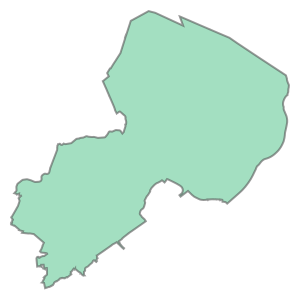

In [23]:
gemeenten.loc[17, 'geometry']

#
# Your code goes here
#

gemeenten.loc[342, 'geometry']

# 7.2 Data mapping

A choropleth for categorical variables simply assigns a different color to every potential value in the series. The main requirement in this case is then for the color scheme to reflect the fact that different values are not ordered or follow a particular scale.

We can create categorical choropleths with geopandas. The following code displays each polygon as whether it is a polygon representing land, water with a legend.


GM_CODE          GM_NAAM H2O         OAD        STED  BEV_DICHTH  \
0  GM0034           Almere  JA -99999999.0 -99999999.0 -99999999.0   
1  GM0050         Zeewolde  JA -99999999.0 -99999999.0 -99999999.0   
2  GM0060          Ameland  JA -99999999.0 -99999999.0 -99999999.0   
3  GM0072        Harlingen  JA -99999999.0 -99999999.0 -99999999.0   
4  GM0088  Schiermonnikoog  JA -99999999.0 -99999999.0 -99999999.0   

     AANT_INW    AANT_MAN  AANT_VROUW  P_00_14_JR  ...  P_GEBBL_NE  \
0 -99999999.0 -99999999.0 -99999999.0 -99999999.0  ... -99999999.0   
1 -99999999.0 -99999999.0 -99999999.0 -99999999.0  ... -99999999.0   
2 -99999999.0 -99999999.0 -99999999.0 -99999999.0  ... -99999999.0   
3 -99999999.0 -99999999.0 -99999999.0 -99999999.0  ... -99999999.0   
4 -99999999.0 -99999999.0 -99999999.0 -99999999.0  ... -99999999.0   

      OPP_TOT    OPP_LAND   OPP_WATER  JRSTATCODE  JAAR  \
0 -99999999.0 -99999999.0 -99999999.0  2023GM0034  2023   
1 -99999999.0 -99999999.0 -99999999.0  2023GM0050  2023   
2 -99999999.0 -99999999.0 -99999999.0  2023GM0060  2023   
3 -99999999.0 -99999999.0 -99999999.0  2023GM0072  2023   
4 -99999999.0 -99999999.0 -99999999.0  2023GM0088  2023   

                          layer  \
0  2023 — gemeente_2023_v1water   
1  2023 — gemeente_2023_v1water   
2  2023 — gemeente_2023_v1water   
3  2023 — gemeente_2023_v1water   
4  2023 — gemeente_2023_v1water   

                                                path  \
0  \\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...   
1  \\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...   
2  \\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...   
3  \\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...   
4  \\cbsp.nl\Productie\primair\TOP\Werk\KWB_buurt...   

                                            geometry  \
0  MULTIPOLYGON (((150087.299 479382.379, 150000....   
1  MULTIPOLYGON (((155047.320 474836.246, 155049....   
2  POLYGON ((196000.000 608000.000, 195250.000 60...   
3  MULTIPOLYGON (((158000.000 581000.000, 158331....   
4  POLYGON ((219000.000 616201.447, 219000.000 61...   

                                     coords  
0  (142126.64086094766, 496236.14450001717)  
1   (166284.93327499047, 480787.9726500511)  
2             (179375.0, 602583.3329999447)  
3    (147757.0088231566, 571859.8220000267)  
4    (215349.3268323614, 610399.8863501549)  

[5 rows x 40 columns]

<Axes: >

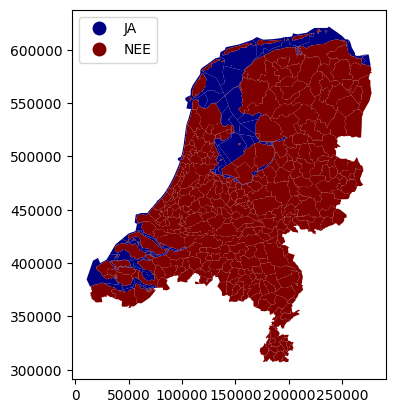

In [24]:
display(gemeenten.head())

gemeenten.plot(column='H2O', cmap='jet', categorical=True, legend=True, legend_kwds={'loc': 'upper left'})

Remove all the polygons representing water and find the number of municipalities in 2023.

number of municipalities in 2023: 343.


<Axes: >

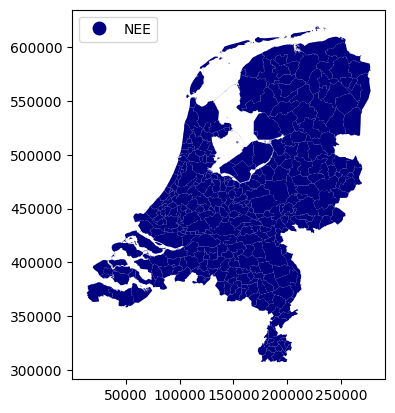

In [25]:
#
# Your code goes here
#

gemeenten = gemeenten[gemeenten['H2O'] == 'NEE']
num_munincipalities2023 = gemeenten["GM_CODE"].nunique()
print(f'number of municipalities in 2023: {num_munincipalities2023}.')
gemeenten.plot(column='H2O', cmap='jet', categorical=True, legend=True, legend_kwds={'loc': 'upper left'})


We can create a map that displays the polygons with colors assigned by some feature values. The following code calculates the area of each polygon. These values can be assigned a color specified by the selected colormap.  Then a new geopandas column called 'area' is created and assigned the area information.  You will see that smaller polygons have lower size and vice versa.  

/home/codespace/.python/current/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

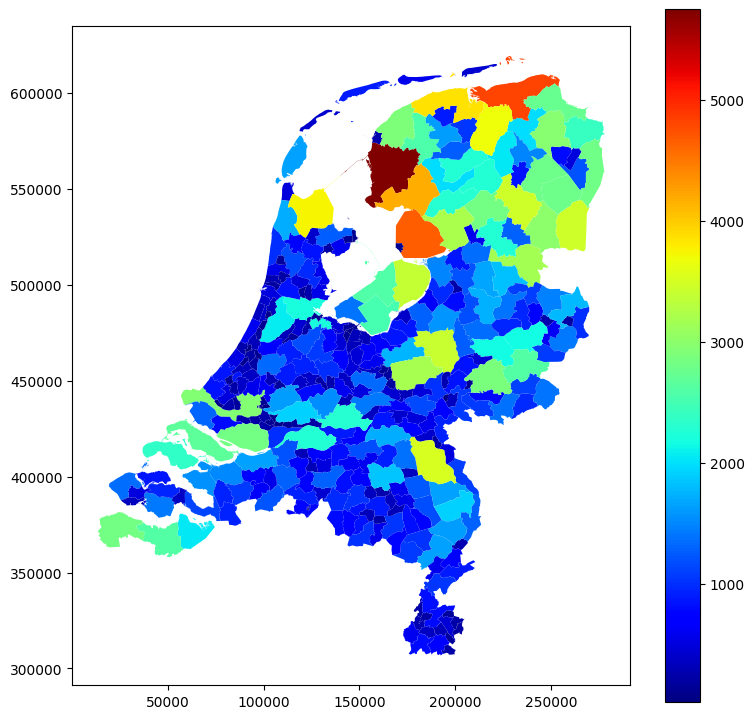

In [26]:
gemeenten.loc[:, 'area'] = gemeenten.geometry.area / 100000
gemeenten.plot(figsize=(9, 9), column='area', cmap='jet', legend=True)

# 7.3 Quantiles
One solution to obtain a more balanced classification scheme is using quantiles. This, by definition, assigns the same amount of values to each bin: the entire series is laid out in order and break points are assigned in a way that leaves exactly the same amount of observations between each of them. This "observation-based" approach contrasts with the "value-based" method of equal intervals and, although it can obscure the magnitude of extreme values, it can be more informative in cases with skewed distributions.

<Axes: >

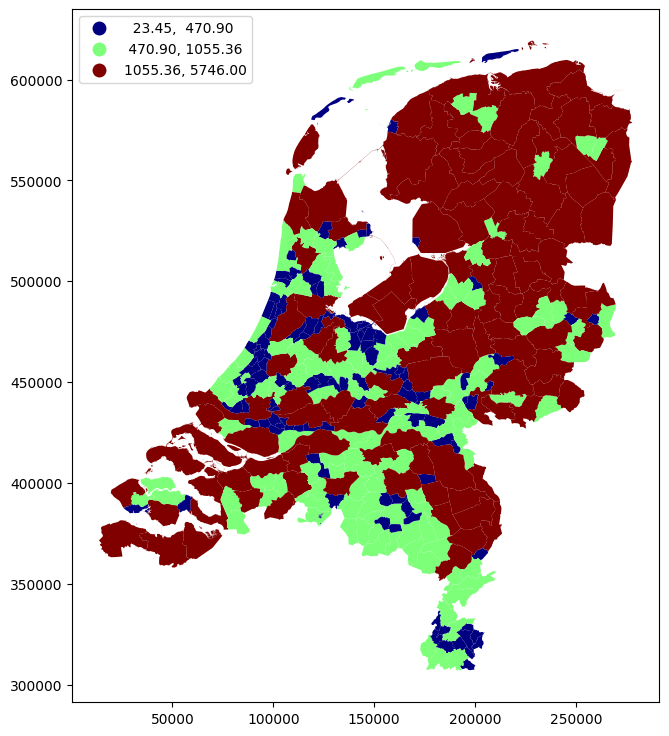

In [27]:
gemeenten.plot(figsize=(9, 9), column='area', scheme='QUANTILES', k=3, cmap='jet', legend=True, legend_kwds={'loc': 'upper left'})